In [1]:
# Librerias
import random
import numpy as np
from matplotlib import use
import matplotlib.pyplot as plt
from sympy import symbols, Eq, Point3D, Plane, solve, Line3D
import pandas as pd

# use('Qt5Agg')

In [2]:
inter = None
color_t = None
caras = None
vertex = None
normal = None
M = None
A = None
mp = None
eigenvalues = None
eigenvectors = None
axis = None
traces = None
tri = None
color_m = None
size = None

In [3]:
def new_plot():
    global axis
    fig = plt.figure()
    axis = fig.add_subplot(111, projection='3d')

def build_box():
        lines = [
            [0, 1], [0, 2], [0, 4],
            [1, 3], [1, 5], [2, 3],
            [2, 6], [3, 7], [4, 5],
            [4, 6], [5, 7], [6, 7]
        ]
        for line in lines:
            axis.plot(
                [vertex[line[0], 0], vertex[line[1], 0]],
                [vertex[line[0], 1], vertex[line[1], 1]],
                [vertex[line[0], 2], vertex[line[1], 2]],
                color='black'
            )

def print_plot():
    axis.set_xlabel('X')
    axis.set_ylabel('Y')
    axis.set_zlabel('Z')

    axis.legend()
    # plt.xlim(5, 15)
    # plt.ylim(-5, 5)
    plt.show()

In [4]:
# Carga los datos de la fractura desde un archivo de texto.
dataset = []
with open("FRAC0019_nrIter27.txt", 'r') as file:
    for line in file:
        values = [float(value) for value in line.split()]
        dataset.append(values)
M = np.array(dataset)

In [5]:
"""
    Calcula la matriz A (matriz de covarianza) de una matriz M y
    los autovalores y autovectores
"""
def load_matrix():
    global A, mp
    print(len(M))
    #M = M[400:440]

    A = np.dot(M.T, M)

    mp = np.mean(M, axis=0)

    eigenvalues, eigenvectors = np.linalg.eig(A)

load_matrix()

540


In [6]:
def get_box():
    """
        Calcula los vértices de la caja que encierra la fractura (matriz m)
    """
    global vertex
    points = M - mp
    _eigenvalues, _eigenvectors = np.linalg.eig(np.cov(points, rowvar=False))
    points = np.dot(points, _eigenvectors)

    # Calcula los límites de la caja en el nuevo sistema de coordenadas
    min_limits = np.min(points, axis=0)
    max_limits = np.max(points, axis=0)

    # Crear puntos de los límites de la caja en el sistema transformado
    vertex = np.array(np.meshgrid([min_limits[0], max_limits[0]], [min_limits[1], max_limits[1]],
                                        [min_limits[2], max_limits[2]])).T.reshape(-1, 3)

    # Transformar los vértices de la caja de vuelta al sistema original
    vertex = np.dot(vertex, _eigenvectors.T) + mp

get_box()

In [7]:
def color_points():
    global color_m, size
    color_m = []
    size = int(len(M) / 20)
    for i in range(size):
        r = [random.random(), random.random(), random.random()]
        color_m.append(r)

    color_m = np.array(color_m)

color_points()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


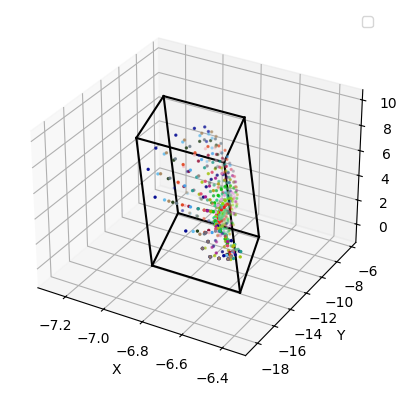

In [8]:
"""
    Representación de los datos en 3D utilizando Matplotlib
"""
def print_points():
    for i in range(size):
        m = M[i * 20:i * 20 + 20]
        axis.scatter(m[:, 0], m[:, 1], m[:, 2], color=color_m[i], s=2)
    

new_plot()
build_box()
print_points()
print_plot()


In [9]:
def triangularization():
    """
        Realizar la triangulación de los puntos, teniento en cuenta que cada 20 puntos se apueden realizar
        triangulaiones con los siguientes 2o puntos.

        tri alamacena la dirección de los puntos que forman un triangulo
    """
    global color_t, tri
    color_t = []
    tri = []
    for i in range(0, size - 1):
        for j in range(20):
            if j == 19:
                tri.append([j + (20 * i), j + (20 * (i + 1)), 0 + (20 * (i + 1))])
                tri.append([j + (20 * i), 0 + (20 * (i + 1)), 0 + (20 * i)])
            else:
                tri.append([j + (20 * i), j + (20 * (i + 1)), (j + 1) + (20 * (i + 1))])
                tri.append([j + (20 * i), (j + 1) + (20 * (i + 1)), (j + 1) + (20 * i)])

            color = (color_m[i] + 2 * color_m[i + 1]) / 3
            color_t.append(color)
            color = (2 * color_m[i] + color_m[i + 1]) / 3
            color_t.append(color)
    color_t = np.array(color_t)
    tri = np.array(tri)

triangularization()

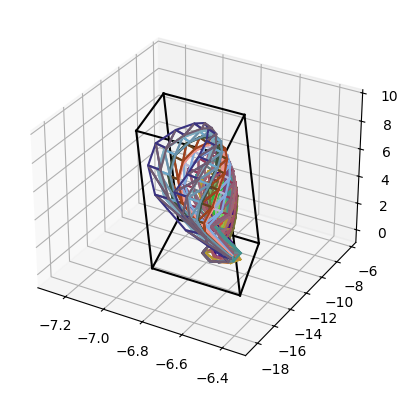

In [10]:
"""
    graficar triangularizacion
"""
def print_triangles():
    for s in range(len(tri)):
        triangle = np.array([M[tri[s][0]], M[tri[s][1]], M[tri[s][2]], M[tri[s][0]]])
        axis.plot(triangle[:, 0], triangle[:, 1], triangle[:, 2], color=color_t[s])

new_plot()
build_box()
print_triangles()

In [11]:
def norm():
    """
    sacar la norma de cada triangulo
    """
    global normal
    normal = []
    aux = 0
    for triangle in tri:
        p1, p2, p3 = M[triangle]
        v1 = p2 - p1
        v2 = p3 - p1
        n = np.cross(v1, v2)
        normal.append(n / np.linalg.norm(n))

norm()

C:\Users\julia\AppData\Local\Temp\ipykernel_9752\968828340.py:13: RuntimeWarning: invalid value encountered in divide
  normal.append(n / np.linalg.norm(n))


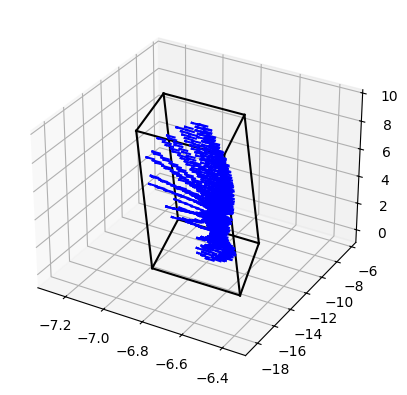

In [12]:
def print_norm():
        """
        graficar la norma de los triangulos
        """
        for i in range(len(normal)):
            mp = np.mean(M[tri[i]], axis=0)
            v = 0.05 * normal[i]
            axis.quiver(mp[0], mp[1], mp[2], v[0], v[1], v[2], color='b')

new_plot()
build_box()
print_norm()

In [13]:
print(len(tri), len(normal), len(color_t))

df_t = pd.concat([pd.DataFrame(tri), pd.DataFrame(normal), pd.DataFrame(color_t)], axis = 1)
df_t.columns = ["triangles_x", "triangles_y", "triangles_z",
                "norm_x", "norm_y", "norm_z",
                "r", "g", "b"]

if df_t.isnull().any().any():
    df_t = df_t.dropna()
    tri = df_t[["triangles_x", "triangles_y", "triangles_z"]].to_numpy()
    normal = df_t[["norm_x", "norm_y", "norm_z"]].to_numpy()
    color_t = df_t[["r", "g", "b"]].to_numpy()


1040 1040 1040


In [14]:
caras = []
def plane_from_points():
    """
        Calcula los planos a partir de puntos dados y los guarda en la lista.
    """
    points = [[0, 1, 4]]
    #points = [[0, 1, 2], [0, 1, 4], [0, 4, 2], [7, 5, 3], [7, 6, 3], [7, 6, 5]]
    #points = [[0, 1, 4], [7, 6, 5], [7, 6, 3], [0, 4, 2], [7, 5, 3], [0, 1, 2]]
    for p in points:
        p1, p2, p3 = map(Point3D, (vertex[p[0]], vertex[p[1]], vertex[p[2]]))
        caras.append(Plane(p1, p2, p3))

def line_from_point_and_vector(point, vector):
    """
        Crea una línea a partir de un punto y un vector.

        Args:
        - point: Punto inicial de la línea.
        - vector: Vector director de la línea.

        Returns:
        - Línea creada.
    """
    point = Point3D(point)
    direction_point = point + Point3D(*vector)
    line = Line3D(point, direction_point)
    return line

def direction_points(punto_inicial, vector_director, distancia):
    """
        Calcula un punto final dado un punto inicial, un vector director y una distancia.

        Args:
        - punto_inicial: Punto inicial.
        - vector_director: Vector director.
        - distancia: Distancia desde el punto inicial al punto final.

        Returns:
        - Punto final calculado.
        """
    norma_vector = np.linalg.norm(vector_director)
    direccion = vector_director / norma_vector
    punto_final = punto_inicial + distancia * direccion
    return punto_final

def intersection_plane_line(line):
        """
            Args:
            - line: Línea con la que se calcula la intersección.

            Returns:
            - Lista de puntos de intersección, si hay alguno, o None en caso contrario.
        """
        intersect = []
        for plane in caras:
            intersection = plane.intersection(line)
            if len(intersection) == 1:  # Solo hay un punto de intersección
                # intersection_point = intersection[0]
                intersect.append(intersection)
                # return inter
        if len(intersect) > 0:
            return intersect
        else:
            return None

In [15]:
def intersection():
    """
        Calcula las intersecciones entre las normales de los triángulos y la caja, y guarda los puntos en la lista
        inter.
    """
    global inter
    inter = []
    plane_from_points()
    print("caras", len(caras))
    aux = 0
    for i in range(len(normal)):
        mp = np.mean(M[tri[i]], axis=0)
        v = normal[i]
        line = line_from_point_and_vector(mp, v)
        op = direction_points(mp, v, 1)
        p = intersection_plane_line(line)
        print(aux)
        aux += 1
        if p is None: continue
        for pp in p:
            pp = [pp[0].x, pp[0].y, pp[0].z]
            inter.append(pp)
    inter = np.array(inter)
    print('len', len(inter), len(normal))

intersection()

caras 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

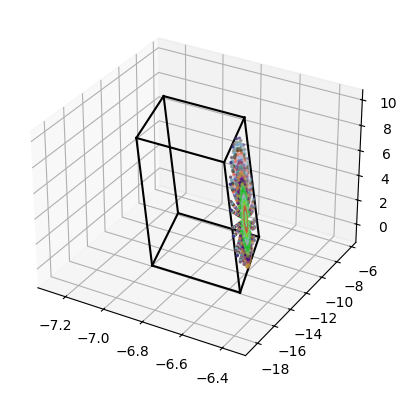

In [16]:
def print_intersection():
    # color_t = color_t[:len(inter)]
    axis.scatter(inter[:, 0], inter[:, 1], inter[:, 2], color=color_t, s=2)

new_plot()
build_box()
print_intersection()